In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import ensemble
from sklearn import linear_model

import zillow

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

# Load and Inspect Data

In [2]:
df = zillow.LoadTabularData("data/")

In [3]:
zillow.LoadImageDataIntoDataFrame(df, "data/")

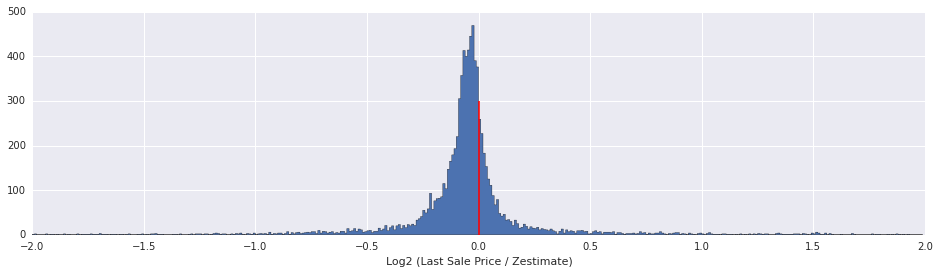

In [22]:
figsize(16, 4)
plt.hist(df.log_sold_to_zestimate, bins=np.arange(-2, 2, 0.01), histtype="stepfilled")
plt.vlines(0, 0, 300, edgecolor="red", alpha=0.9)
plt.xlabel("Log2 (Last Sale Price / Zestimate)")
plt.show()

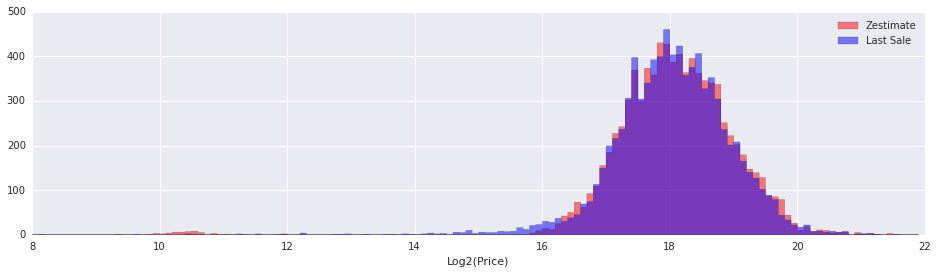

In [5]:
figsize(16, 4)
plt.hist(
    np.log2(df.zestimate), bins=np.arange(8, 22, 0.1),
    color="red", alpha=0.5, histtype="stepfilled", label="Zestimate")
plt.hist(
    np.log2(df.last_sold), bins=np.arange(8, 22, 0.1),
    color="blue", alpha=0.5, histtype="stepfilled", label="Last Sale")
plt.xlabel("Log2(Price)")
plt.legend()
plt.show()

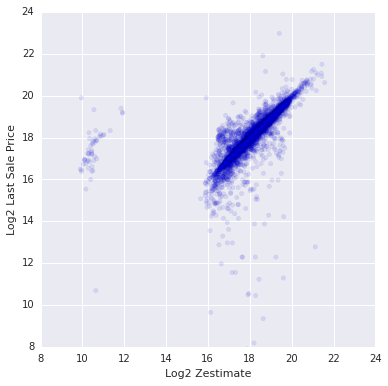

In [6]:
figsize(6, 6)
plt.scatter(np.log2(df.zestimate), np.log2(df.last_sold), alpha=0.1)
plt.xlabel("Log2 Zestimate")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.show()

# Prepare Data for Training

In [7]:
df["region"] = df.city + df.state + df.zip.astype(str)
region_encoder = dict((r, n) for n, r in enumerate(df.region.unique()))
df["region_code"] = df.region.map(lambda r: region_encoder[r])

In [8]:
ixs = np.arange(df.shape[0])
np.random.shuffle(ixs)
n_test = int(df.shape[0] / 10)
test_ixs = ixs[:n_test]
train_ixs = ixs[n_test:]
test_df = df.iloc[test_ixs]
train_df = df.iloc[train_ixs]

# Traditional ML & Statistical Models Trained on Home Facts

In [33]:
reload(zillow)
vectorizer, vf = zillow.VectorizeFacts(df.region.map(lambda r: [r]) + df.facts)
vf.shape

(8523, 406)

In [28]:
df.columns

Index([u'baths', u'beds', u'city', u'facts', u'img_url', u'last_sold',
       u'permits', u'sqft', u'state', u'zestimate', u'zip', u'zpid',
       u'log_sold_to_zestimate', u'image', u'region', u'region_code'],
      dtype='object')

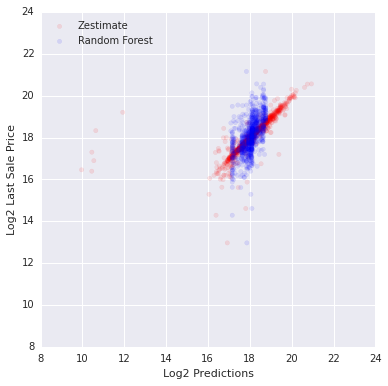

In [50]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, max_leaf_nodes=10, n_jobs=-1)
rfr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

rfr_preds = rfr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    rfr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Random Forest", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

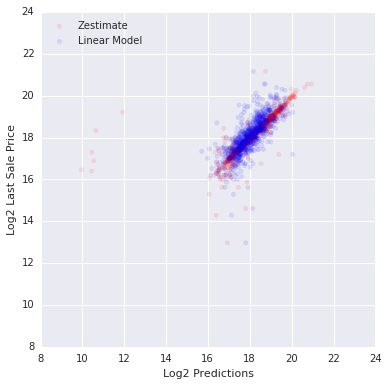

In [48]:
olsr = linear_model.LinearRegression(n_jobs=-1)
olsr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

olsr_preds = olsr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    olsr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Linear Model", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

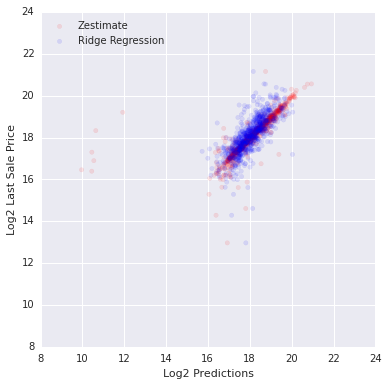

In [54]:
rr = linear_model.Ridge()
rr.fit(vf[train_ixs], np.log2(train_df.last_sold))

rr_preds = rr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    rr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Ridge Regression", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

#### Mean Abs Log2 Error

In [60]:
print "    zestimate", (np.log2(test_df.zestimate) - np.log2(test_df.last_sold)).abs().mean()
print "   ridge reg.", (rr_preds - np.log2(test_df.last_sold)).abs().mean()
print "  linear reg.", (olsr_preds - np.log2(test_df.last_sold)).abs().mean()
print "random forest", (rfr_preds - np.log2(test_df.last_sold)).abs().mean()

    zestimate 0.218183721161
   ridge reg. 0.411460986953
  linear reg. 0.411527045712
random forest 0.559166379755


#### Mean Abs Error

In [61]:
print "    zestimate", (test_df.zestimate - test_df.last_sold).abs().mean()
print "   ridge reg.", (np.exp2(rr_preds) - test_df.last_sold).abs().mean()
print "  linear reg.", (np.exp2(olsr_preds) - test_df.last_sold).abs().mean()
print "random forest", (np.exp2(rfr_preds) - test_df.last_sold).abs().mean()

    zestimate 35485.4424883
   ridge reg. 90867.4512263
  linear reg. 90813.8882497
random forest 120427.675307


# Build a network in Keras to Learn from Images

In [62]:
from keras import models, layers, optimizers, backend

In [63]:
def ConvolutionalRegressor(n_regions):
    # Convolutional portion
    img_model = models.Sequential()

    img_model.add(layers.Conv2D(32, 5, 5, border_mode="same", input_shape=(128, 128, 3)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(48, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(64, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(96, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(128, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))
    
    img_model.add(layers.Conv2D(32, 4, 4, border_mode="valid"))
    img_model.add(layers.Reshape((32,)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    
    # Embedding portion for region
    embed_model = models.Sequential()
    embed_model.add(layers.embeddings.Embedding(n_regions, 16, input_length=1))
    embed_model.add(layers.Reshape((16,)))
    img_model.add(layers.Dropout(0.5))
    
    # Merge
    merged = layers.Merge([img_model, embed_model], mode="concat")
    merged_model = models.Sequential()
    merged_model.add(merged)
    merged_model.add(layers.Dense(10))
    merged_model.add(layers.BatchNormalization())
    merged_model.add(layers.LeakyReLU(0.2))
    merged_model.add(layers.Dense(1))

    return merged_model

In [64]:
cr = ConvolutionalRegressor(max(region_encoder.values()) + 1)

In [ ]:
cr.compile(optimizer="adam", loss="mse")

In [ ]:
cr_history = cr.fit(
    [np.array(train_df.image.tolist()), np.array(train_df.region_code)],
    np.array(np.log2(train_df.last_sold)),
    batch_size=16,
    nb_epoch=5,
    verbose=1,
    validation_data=(
        [np.array(test_df.image.tolist()), np.array(test_df.region_code)],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True)

In [ ]:
df["predictions"] = cr.predict(
    [np.array(df.image.tolist()), np.array(df.region_code)],
    verbose=1)

In [ ]:
test_df.loc[test_ixs, "predictions"] = df.iloc[test_ixs].predictions
target_df = test_df

figsize(6, 6)
plt.scatter(
    np.log2(target_df.zestimate), np.log2(target_df.last_sold),
    alpha=0.2, color="red", label="Zestimate")
plt.scatter(
    target_df.predictions, np.log2(target_df.last_sold),
    alpha=0.2, color="blue", label="Our Predictions")
plt.xlabel("Log2 Predicted Price")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend()
plt.show()